# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Import all the libraries needed

import cv2
import glob
import itertools
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import tensorflow as tf
import os
import matplotlib.gridspec as gridspec
import pandas as pd


In [2]:
# setup some initial variables

checkpoint_var = {}
checkpoint_file = 'data/checkpoint'
checkpoint_force = True
    

---
## Step 0: Load The Data

In [280]:
# Load pickled data
import pickle


# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: Number of testing examples.
n_valid = len(y_valid)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


Initially I got confused on when to use Test vs Validation. the Test set has allot more samples than the validation set. Hence I figured that would be the final set to validate the model against. (Only once...)

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

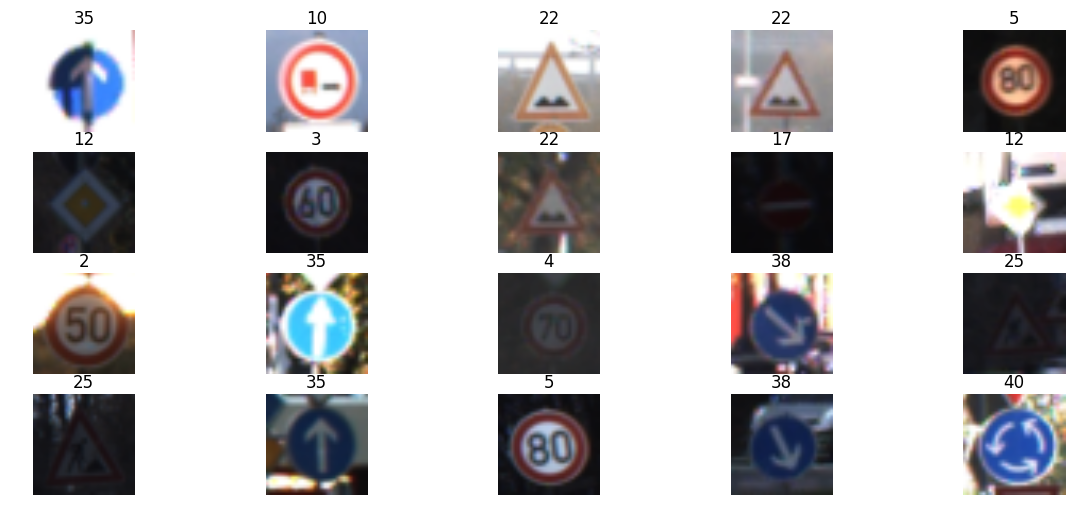

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
random.seed(1525)
# show image of 10 random data points
fig, axs = plt.subplots(4,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(20):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])
    
#len(set( y_train))


Upon looking at these 20 random images, it struck me that brightness is something to carefully consider. I'm also suprised by the poor quality of the images, pleasantly surpised as it means a well performing model will perform well in real world scenarios.

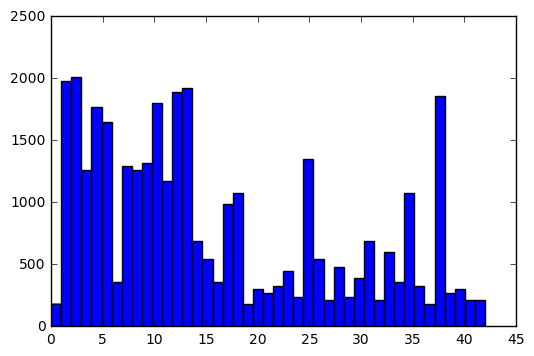

In [285]:
plt.hist(y_train,bins=43);

The classes are heavily imbalanced. My first instinct is to find a method to correct for the imbalance.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
# Function to generate transformed images
# from https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb

# These are functions to add images to the training set by changing an existing image

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
      img = augment_brightness_camera_images(img)

    return img

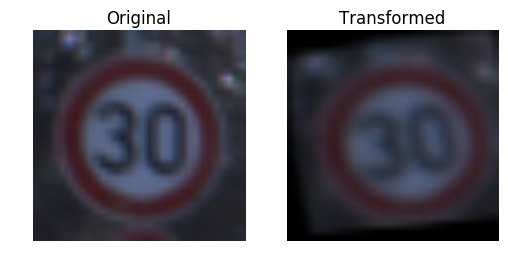

In [284]:
img = X_train[4012]
trans_img = transform_image(img,20,5,5,1)

fig, axs = plt.subplots(1,2)
axs = axs.ravel()
#fig.subplots_adjust(hspace = .2, wspace=.001)
axs[0].axis('off')
axs[0].imshow(img)
axs[0].set_title('Original')
axs[1].axis('off')
axs[1].imshow(trans_img)
axs[1].set_title('Transformed')

In [9]:
# https://github.com/jeremy-shannon/CarND-Traffic-Sign-Classifier-Project

# add 400 extra images for each class

print('X, y shapes:', X_train.shape, y_train.shape)

input_indices = []
output_indices = []

min_sample = 400

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    #if n_samples < min_sample:
    for i in range(min_sample):
        input_indices.append(class_indices[0][i%n_samples])
        output_indices.append(X_train.shape[0])
        new_img = X_train[class_indices[0][i % n_samples]]
        new_img = transform_image(new_img,15,8,4,brightness=1)
        X_train = np.concatenate((X_train, [new_img]), axis=0)
        y_train = np.concatenate((y_train, [class_n]), axis=0)
        if i % 50 == 0:
            print('|', end='')
        elif i % 10 == 0:
            print('-',end='')
    print('')
            
print('X, y shapes:', X_train.shape, y_train.shape)

X, y shapes: (34799, 32, 32, 3) (34799,)
0 : |----|----|----|----|----|----|----|----
1 : |----|----|----|----|----|----|----|----
2 : |----|----|----|----|----|----|----|----
3 : |----|----|----|----|----|----|----|----
4 : |----|----|----|----|----|----|----|----
5 : |----|----|----|----|----|----|----|----
6 : |----|----|----|----|----|----|----|----
7 : |----|----|----|----|----|----|----|----
8 : |----|----|----|----|----|----|----|----
9 : |----|----|----|----|----|----|----|----
10 : |----|----|----|----|----|----|----|----
11 : |----|----|----|----|----|----|----|----
12 : |----|----|----|----|----|----|----|----
13 : |----|----|----|----|----|----|----|----
14 : |----|----|----|----|----|----|----|----
15 : |----|----|----|----|----|----|----|----
16 : |----|----|----|----|----|----|----|----
17 : |----|----|----|----|----|----|----|----
18 : |----|----|----|----|----|----|----|----
19 : |----|----|----|----|----|----|----|----
20 : |----|----|----|----|----|----|----|----
21 

In [10]:
##### Save some varfiables


if not os.path.isfile(checkpoint_file) or checkpoint_force:
            checkpoint_var['X_train'] = X_train
            checkpoint_var['y_train'] = y_train
            checkpoint_var['X_test'] = X_test
            checkpoint_var['y_test'] = y_test
            checkpoint_var['X_valid'] = X_valid
            checkpoint_var['y_valid'] = y_valid
else: 
     print('Checkpoint Already Exists. Data would be loaded from checkpoint. Set checkpoint_force to force new file.')

In [11]:
# Save the variables
import pickle

if not os.path.isfile(checkpoint_file) or checkpoint_force:
    print('Caching variables in pickle file...')
    try:
        with open(checkpoint_file, 'wb') as pfile:
            pickle.dump(checkpoint_var, pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', checkpoint_file, ':', e)
        raise
    print('Data cached in pickle file.')
else:
    print('Pickle file already created. Set checkpoint_force to force new file.')

Caching variables in pickle file...
Data cached in pickle file.


In [12]:
# import variables from last save (not entire working yet)
import pickle 
checkpoint_file = 'data/checkpoint'

with open(checkpoint_file, 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data  

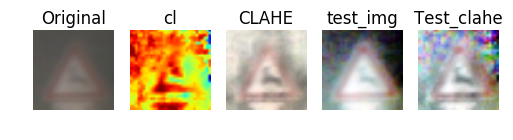

In [286]:
# Testing the CLAHE (Contrast Limited Adaptive Histogram Equalization)

#-----Reading the image-----------------------------------------------------
img = X_train[410]

#-----Converting image to HLS Color model----------------------------------- 
lab = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#-----Splitting the HLS image to different channels-------------------------
h, s, l = cv2.split(lab)


#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
cl = clahe.apply(l)


#-----Merge the CLAHE enhanced L-channel with the h and s channel-----------
limg = cv2.merge((h,s,cl))

#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_HSV2BGR)



r,g,b = cv2.split(img)

rl =cv2.equalizeHist(r)
gl =cv2.equalizeHist(g)
bl =cv2.equalizeHist(b)

test_img  = cv2.merge((rl,gl,bl))

#-----Converting image to HLS Color model----------------------------------- 
lab = cv2.cvtColor(test_img, cv2.COLOR_BGR2HSV)

#-----Splitting the HLS image to different channels-------------------------
h, s, l = cv2.split(lab)


#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
cl = clahe.apply(l)


#-----Merge the CLAHE enhanced L-channel with the h and s channel-----------
limg = cv2.merge((h,s,cl))

#-----Converting image from LAB Color model to RGB model--------------------
Test_clahe = cv2.cvtColor(limg, cv2.COLOR_HSV2BGR)



fig, axs = plt.subplots(1,5)
axs = axs.ravel()
#fig.subplots_adjust(hspace = .2, wspace=.001)
axs[0].axis('off')
axs[0].imshow(img)
axs[0].set_title('Original')
axs[1].axis('off')
axs[1].imshow(cl)
axs[1].set_title('cl')
axs[2].axis('off')
axs[2].imshow(final)
axs[2].set_title('CLAHE')
axs[3].axis('off')
axs[3].imshow(test_img)
axs[3].set_title('test_img')
axs[4].axis('off')
axs[4].imshow(Test_clahe)
axs[4].set_title('Test_clahe')


#_____END_____#

From these (and others that I've tested), it seems to me that a simple RGB histogram correction would be the best option

In [14]:
# Implement the histogram correction function

def HIST_trans(pre_img):
    r,g,b = cv2.split(pre_img)

    rl =cv2.equalizeHist(r)
    gl =cv2.equalizeHist(g)
    bl =cv2.equalizeHist(b)

    final  = cv2.merge((rl,gl,bl))


    return final


In [289]:
# Apply the Hist correction to all the images


for i in range(0,len(X_test)-1):
    X_test[i] = HIST_trans(X_test[i])
    
for i in range(0,len(X_train)-1):
    X_train[i] = HIST_trans(X_train[i])
    
for i in range(0,len(X_valid)-1):
    X_valid[i] = HIST_trans(X_valid[i])
    
    

In [16]:
def plot_random_3C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot])
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()

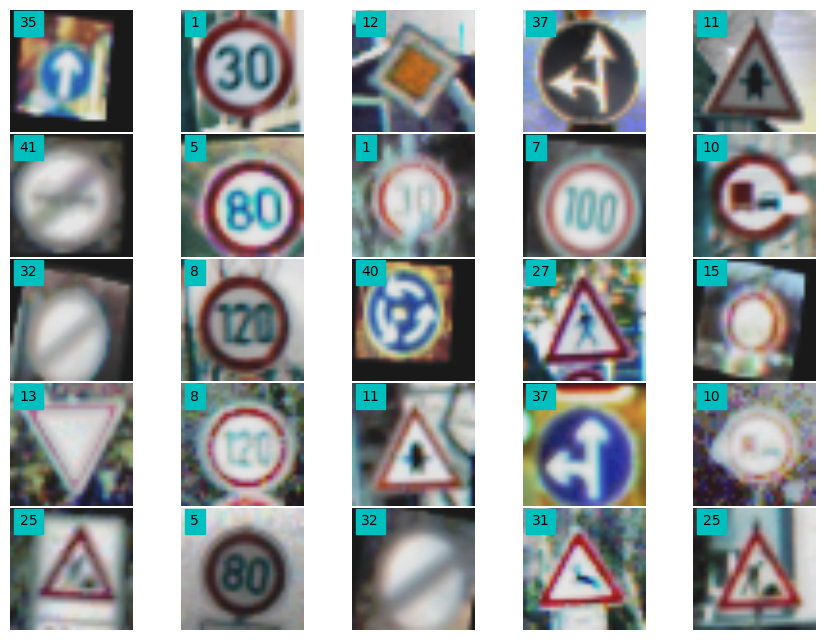

In [204]:
plot_random_3C(5,5,X_train,y_train)

In [290]:
## Normalize the train and test datasets to (-1,1)
## Got stuck  because of dtype issues, dtype: Unsigned integer (0 to 255)
## Going to scale to (0,1)

###v2.0 AS per lessons, I'm going to do MinMax Scaling (0.1,0.9)

X_train = X_train/255 * 0.8 + 0.1
X_test = X_test/255* 0.8 + 0.1
X_valid = X_valid/255* 0.8 + 0.1



In [291]:
print(np.mean(X_train))
print(np.mean(X_test))
print(np.mean(X_valid))

0.512590352477
0.514005586912
0.513341357145


In [ ]:
The train set seems to be slightly different to the rest of the sets. I think it should not be an issue.

In [22]:

# One hot encode labels
def encode_labels(labels):
    labels = (np.arange(n_classes) == labels[:,None]).astype(np.float)
    return labels

In [23]:

y_train_oneh = encode_labels(y_train)
y_test_oneh = encode_labels(y_test)


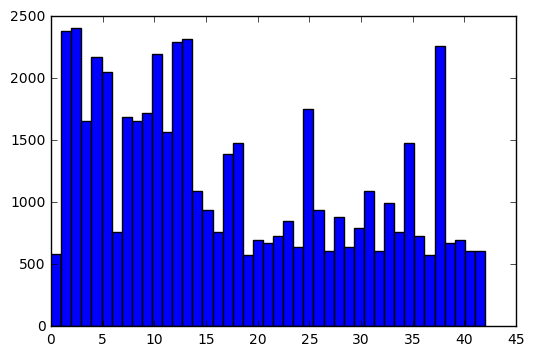

In [24]:
plt.hist(y_train,bins=43);

In [25]:
# Shuffle the data

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

y_train_oneh = encode_labels(y_train)
y_test_oneh = encode_labels(y_test)

### Model Architecture

![title](./img/Lenet5.png)

I used a slightly adjusted Lenet5 architecture. I've read about and seen other architectures that perform better, but I stuck to this one as it was performing adequately. The biggest adjustment was changing the input layer from one channel to three and adding RELU and Dropout to the network. I also played around with the shapes of the fully connected layers. Increasing the size resulted in a better performing model.

In [266]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Define your architecture here.
### Feel free to use as many code cells as needed.

tf.reset_default_graph()



from tensorflow.contrib.layers import flatten

def neural_network(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.05
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    c1_weight = tf.Variable(tf.truncated_normal(shape = (5, 5, 3, 6), mean = mu, stddev = sigma))
    c1_bias = tf.Variable(tf.zeros(6))
    # Apply convolution
    conv_layer1 = tf.nn.conv2d(x, c1_weight, strides=[1, 1, 1, 1], padding='VALID') + c1_bias
    
    # Activation for layer 1
    conv_layer1 = tf.nn.relu(conv_layer1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv_layer1 = tf.nn.avg_pool(conv_layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    c2_weight = tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma))
    c2_bias = tf.Variable(tf.zeros(16))
    # Apply convolution for layer 2
    conv_layer2 = tf.nn.conv2d(conv_layer1, c2_weight, strides=[1, 1, 1, 1], padding='VALID') + c2_bias
    
    # Activation for layer 2
    conv_layer2 = tf.nn.relu(conv_layer2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv_layer2 = tf.nn.avg_pool(conv_layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten to get to fully connected layers. Input = 5x5x16. Output = 400.
    flat = tf.contrib.layers.flatten(conv_layer2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 200.
    fc1_weight = tf.Variable(tf.truncated_normal(shape = (400, 200), mean = mu, stddev = sigma))
    fc1_bias = tf.Variable(tf.zeros(200))
    # Here is the main change versus a convolutional layer - matrix multiplication instead of 2D convolution
    fc1 = tf.matmul(flat, fc1_weight) + fc1_bias
    
    # Activation for the first fully connected layer.
    # Same thing as before
    fc1 = tf.nn.relu(fc1)
    
    # Dropout, to prevent overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 200. Output = 100.
    # Same as the fc1 layer, just with updated output numbers
    fc2_weight = tf.Variable(tf.truncated_normal(shape = (200, 100), mean = mu, stddev = sigma))
    fc2_bias = tf.Variable(tf.zeros(100))
    # Again, matrix multiplication
    fc2 = tf.matmul(fc1, fc2_weight) + fc2_bias
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5 Fully Connected. Input = 100. Output = 43.
    # Since this is the final layer, output needs to match up with the number of classes
    fc3_weight = tf.Variable(tf.truncated_normal(shape = (100, 43), mean = mu, stddev = sigma))
    fc3_bias = tf.Variable(tf.zeros(43))
    # Again, matrix multiplication
    logits = tf.matmul(fc2, fc3_weight) + fc3_bias
    
    return logits, c1_weight,c2_weight,fc1_weight,fc2_weight,fc3_weight


# Set placeholder variables for x, y, and the keep_prob for dropout
# Also, one-hot encode y
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)


# Setting learning rate, loss functions, and optimizer
rate = 1e-3

           

logits, c1_weight,c2_weight,fc1_weight,fc2_weight,fc3_weight = neural_network(x)

regularizers = (tf.nn.l2_loss(c1_weight) 
                + tf.nn.l2_loss(c2_weight) + tf.nn.l2_loss(fc1_weight) 
                + tf.nn.l2_loss(fc2_weight) + tf.nn.l2_loss(fc3_weight))

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)+1e-5*regularizers
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


# The below is used in the validation part of the neural network
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy =  sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [267]:
EPOCHS = 35
BATCH_SIZE = 75

In [268]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.


save_file = './graph/train_model.ckpt'
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.7})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # Save the model
    saver.save(sess, save_file)
    print('Trained Model Saved.')

Training...

EPOCH 1 ...
Validation Accuracy = 0.674

EPOCH 2 ...
Validation Accuracy = 0.782

EPOCH 3 ...
Validation Accuracy = 0.804

EPOCH 4 ...
Validation Accuracy = 0.858

EPOCH 5 ...
Validation Accuracy = 0.863

EPOCH 6 ...
Validation Accuracy = 0.887

EPOCH 7 ...
Validation Accuracy = 0.880

EPOCH 8 ...
Validation Accuracy = 0.898

EPOCH 9 ...
Validation Accuracy = 0.911

EPOCH 10 ...
Validation Accuracy = 0.906

EPOCH 11 ...
Validation Accuracy = 0.907

EPOCH 12 ...
Validation Accuracy = 0.916

EPOCH 13 ...
Validation Accuracy = 0.923

EPOCH 14 ...
Validation Accuracy = 0.918

EPOCH 15 ...
Validation Accuracy = 0.922

EPOCH 16 ...
Validation Accuracy = 0.921

EPOCH 17 ...
Validation Accuracy = 0.934

EPOCH 18 ...
Validation Accuracy = 0.927

EPOCH 19 ...
Validation Accuracy = 0.934

EPOCH 20 ...
Validation Accuracy = 0.931

EPOCH 21 ...
Validation Accuracy = 0.938

EPOCH 22 ...
Validation Accuracy = 0.937

EPOCH 23 ...
Validation Accuracy = 0.939

EPOCH 24 ...
Validation Accura

In [293]:
with tf.Session() as sess:
    saver.restore(sess, save_file)

    test_accuracy = evaluate(X_train, y_train)

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9941952390922082


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

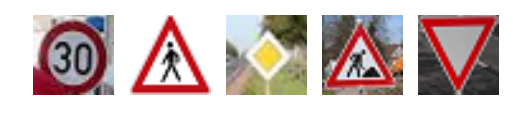

In [270]:


import os
import matplotlib.image as mpimg
add_pics = os.listdir("./OwnSigns/")
# Drop the mac's created '.DS_Store' file


# Show the images, add to a list to process for classifying
add_pics_data = []
j=0
fig, axs = plt.subplots(1,len(add_pics))
axs = axs.ravel()
for i in add_pics:
    i = './OwnSigns/' + i
    #image = mpimg.imread(i)
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #print(image)
    add_pics_data.append(image)
    axs[j].axis('off')
    axs[j].imshow(image)
    j=j+1
    #plt.imshow(image)
    #plt.show()
    
namenewdata = [name for name in os.listdir("./OwnSigns/")]



### Predict the Sign Type for Each Image

In [271]:
# Make into numpy array for processing
add_pics_data = np.asarray(add_pics_data)

# First, double-check the image shape to make sure it matches the original data's 32x32x3 size
print(add_pics_data.dtype)
#print(add_pics_data[0])

uint8


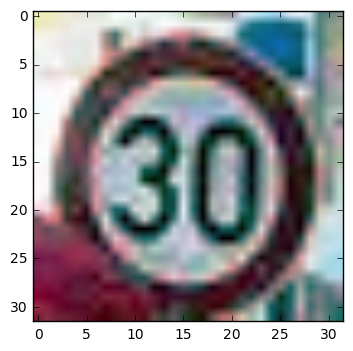

In [272]:
#pre-process new images


for i in range(len(add_pics_data)):
    add_pics_data[i] = HIST_trans(add_pics_data[i])

plt.imshow(add_pics_data[0])
    
add_pics_data = (add_pics_data/255 * 0.8) + 0.1



In [273]:
add_pics_data_orig = (add_pics_data-0.1)/0.8*255
add_pics_data_orig = add_pics_data_orig.astype('uint8')


In [274]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./graph/train_model.ckpt.meta')
    new_saver.restore(sess, './graph/train_model.ckpt')
    new_pics_classes = sess.run(logits, feed_dict={x: add_pics_data, keep_prob : 1.0})
    
    #new_saver = tf.train.import_meta_graph('my-save-dir/my-model-10000.meta')
    #new_saver.restore(sess, 'my-save-dir/my-model-10000')

In [275]:
import pandas as pd
data_pd = pd.read_csv('signnames.csv')


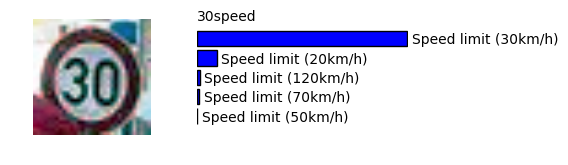

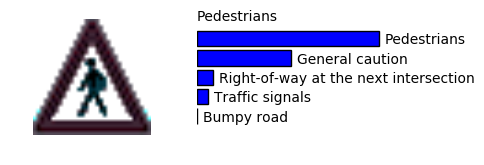

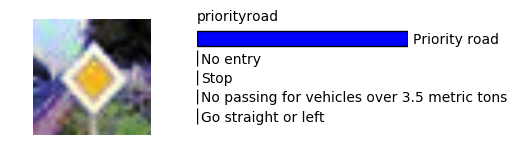

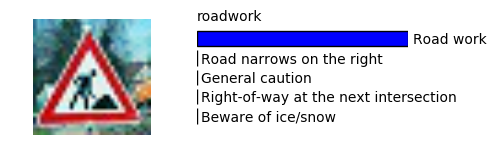

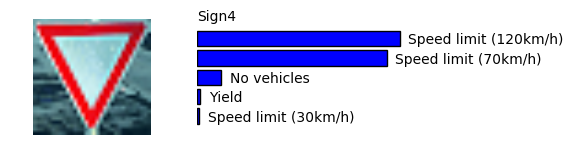

In [294]:
with tf.Session() as sess:
    saver.restore(sess, save_file)

    feed_dict_new = {x: add_pics_data,
                                keep_prob: 1}
    
    softmax_logits = tf.nn.softmax(logits)
    top5 = tf.nn.top_k(softmax_logits, k=5)
    
    #top5 = tf.nn.top_k(logits, 5)

    predictions = sess.run(logits,feed_dict = feed_dict_new)
    top5_pred = sess.run([logits, top5], feed_dict=feed_dict_new)
    
    my_softmax_logits = sess.run(softmax_logits,feed_dict = feed_dict_new)
    my_top_5 = sess.run(top5, feed_dict=feed_dict_new)

    for i in range(5):
        
        plt.figure(figsize = (5,1.5))
        gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])
        plt.subplot(gs[0])
        plt.imshow(add_pics_data_orig[i])
        plt.axis('off')
        plt.subplot(gs[1])
        plt.barh(6-np.arange(5),top5_pred[1][0][i], align='center')
        for i_label in range(5):
            plt.text(top5_pred[1][0][i][i_label]+.02,6-i_label-.25,
                data_pd['SignName'][top5_pred[1][1][i][i_label]])
        plt.axis('off');
        plt.text(0,6.95,namenewdata[i].split('.')[0]);
        plt.show();

### Analyze Performance

The model got 4 out of 5. 

It classified the Yield sign incorrectly and I honestly have no idea why.

80% accuracy 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

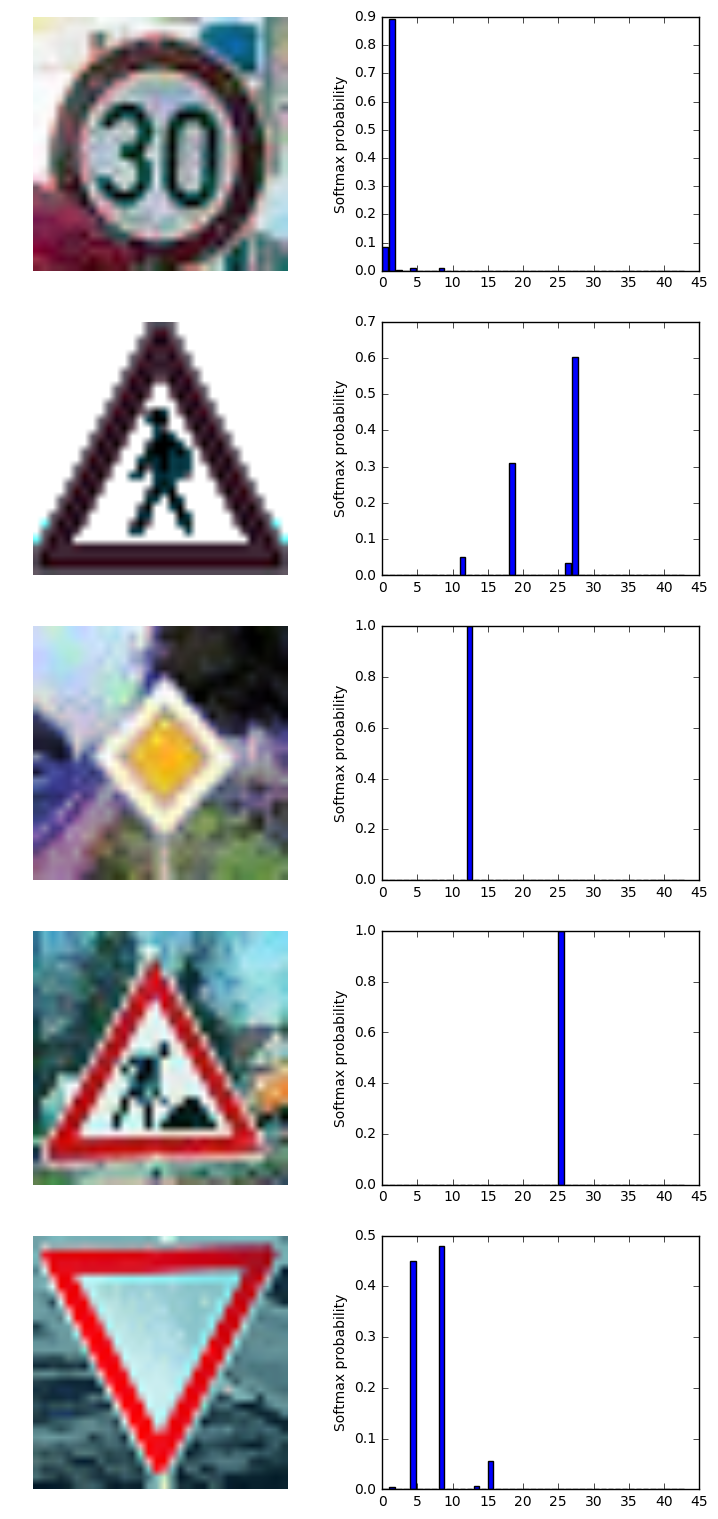

In [278]:
fig, axs = plt.subplots(5,2, figsize=(9, 19))
axs = axs.ravel()

for i in range(10):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(add_pics_data_orig[i//2])
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')

From the softmax probabilities, you can see that it was fairly certain on 3 correctly predicted signs 
but fairly uncertain on the incorrectly classified yield sign.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 